/home/bence/PycharmProjects/Temalabor/.venv/lib/python3.12/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/home/bence/PycharmProjects/Temalabor/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


         Current function value: 6193.053920
         Iterations: 0
         Function evaluations: 74
         Gradient evaluations: 62


/home/bence/PycharmProjects/Temalabor/.venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1330: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/bence/PycharmProjects/Temalabor/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


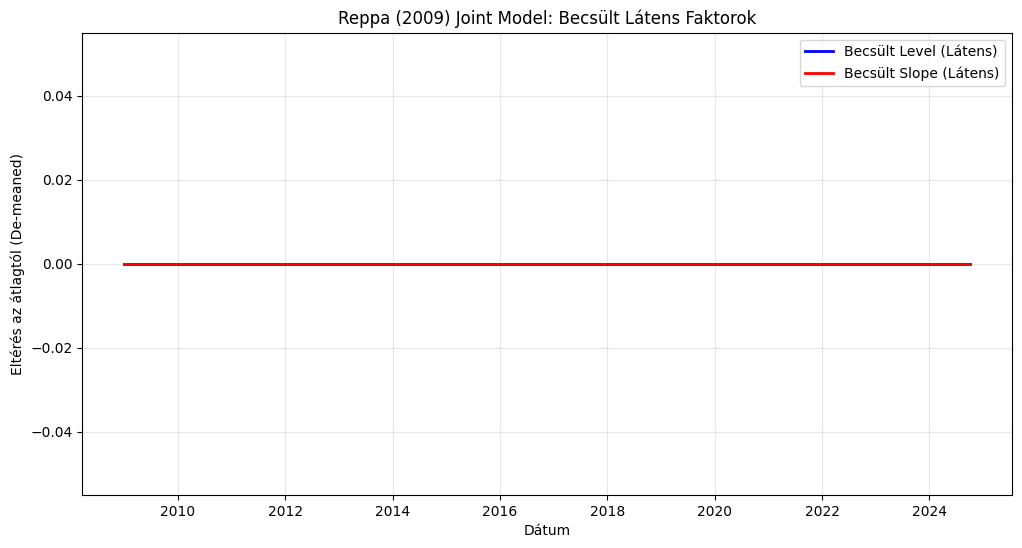

                                                                                 Statespace Model Results                                                                                 
Dep. Variable:     ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180', 'Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg']   No. Observations:                   64
Model:                                                                                                                            ReppaJointModel   Log Likelihood             -396355.451
Date:                                                                                                                            Wed, 14 Jan 2026   AIC                         792734.902
Time:                                                                                                                                    22:08:30   BIC                         792760.808
Sample:                                                          

/home/bence/PycharmProjects/Temalabor/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
/home/bence/PycharmProjects/Temalabor/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import matplotlib.pyplot as plt

# 1. ADATELŐKÉSZÍTÉS (A Te kódod alapján)
file_path = 'NS_adatok_cln.xlsx'
df = pd.read_excel(file_path)
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)

yield_cols = ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180']
maturities = [0.033, 1, 3, 6, 12, 36, 60, 120, 180]
maturities_years = np.array([0.033, 1, 3, 6, 12, 36, 60, 120, 180]) / 12
yields_data = df[yield_cols]


gdp_log = np.log(df['GDP'])
cycle, trend = sm.tsa.filters.hpfilter(gdp_log, lamb=1600)
df['Output_Gap'] = cycle * 100

# Egyéb változók
df['Exchange_Rate_Chg'] = np.log(df['Árfolyam']).diff() * 100
df['Base_Rate'] = df['Kamat']
df['Inflation'] = df['Infláció']
# Adatok tisztítása és de-meanelés (Reppa de-meaned változókat használ)
macro_cols = ['Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg']
combined_df = pd.concat([yields_data, df[macro_cols]], axis=1).dropna()

means = combined_df.mean()
data_dm = combined_df - means # De-meaned adatok

# Paraméterek
maturities = np.array([0.033, 1, 3, 6, 12, 36, 60, 120, 180]) # hónapokban
k_yields = len(maturities)
k_macro = len(macro_cols)
k_states = 2 + k_macro # 2 látens faktor (Level, Slope) + 4 makro
class ReppaJointModel(MLEModel):
    def __init__(self, endog, maturities):
        k_states = 6
        super().__init__(endog, k_states=k_states, initialization='stationary')
        self.maturities = maturities
        self['design'] = np.zeros((self.k_endog, self.k_states))
        self['design'][k_yields:, 2:] = np.eye(k_macro)

        # FIXÁLJUK a mérési zajt: ne engedjük az optimalizálónak, hogy elszálljon
        # Reppa szerint a hozamok illeszkedése jó, a zaj kicsi (2-40 bázispont)
        self['obs_cov'] = np.zeros((self.k_endog, self.k_endog))

    @property
    def start_params(self):
        # Csak 6 VAR paraméter (főátló) + 6 állapot zaj = 12 paraméter összesen
        # A többit fixen 0-n tartjuk kezdetben
        params = np.zeros(12)
        params[0:6] = 0.8  # VAR főátló kezdőérték
        params[6:12] = 0.01 # Állapot zaj kezdőérték
        return params

    def update(self, params, **kwargs):
        tau = 6.30 # FIXÁLVA Reppa (2009) alapján [cite: 313]

        # Nelson-Siegel súlyok
        self['design'][:k_yields, 0] = 1.0
        self['design'][:k_yields, 1] = (1 - np.exp(-self.maturities / tau)) / (self.maturities / tau)

        # Átmeneti mátrix: CSAK DIAGONÁLIS (egyszerűsített Reppa-modell)
        # Ez drasztikusan csökkenti a paraméterszámot (36-ról 6-ra)
        self['transition'] = np.diag(params[0:6])

        # Állapot zaj (Omega)
        self['state_cov'] = np.diag(np.abs(params[6:12]))

        # Mérési zaj (R): FIXÁLVA kis értékre (pl. 0.01), hogy a modell "dolgozzon"
        # Ha ezt is becsüljük, az optimalizáló hajlamos "elmenekülni"
        self['obs_cov'][:k_yields, :k_yields] = np.eye(k_yields) * 0.01

# Modell futtatása kevesebb paraméterrel
model = ReppaJointModel(data_dm, maturities)
results = model.fit(maxiter=1000, method='bfgs') # A BFGS stabilabb ilyenkor

# --- 4. EREDMÉNYEK VIZUALIZÁCIÓJA (Javított indexelés) ---
# results.smoothed_state alakja (k_states, nobs) -> (6, 64)
states = results.smoothed_state

plt.figure(figsize=(12, 6))
# A states[0, :] az első faktor (Level) minden időpontra
plt.plot(data_dm.index, states[0, :], label='Becsült Level (Látens)', color='blue', linewidth=2)
# A states[1, :] a második faktor (Slope) minden időpontra
plt.plot(data_dm.index, states[1, :], label='Becsült Slope (Látens)', color='red', linewidth=2)

plt.title('Reppa (2009) Joint Model: Becsült Látens Faktorok')
plt.xlabel('Dátum')
plt.ylabel('Eltérés az átlagtól (De-meaned)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(results.summary())